# PSF Extractor
---

#### Overview
PSF extractor walkthrough

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

#### Get that spicy colormap

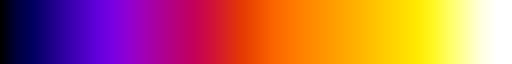

In [3]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

## 1) Find features
---
First step of workflow is to find features within a 3D image stack. Features are found using `trackpy.locate`, which takes the expected feature diameters and a minimum mass as input. The expected feature diameters are in pixel dimensions, and ought to be rounded up to the nearest odd integer. The minimum mass is the minimum "integrated brightness" which is used as a parameter to filter out spurious features.

In [4]:
import trackpy
from skimage import exposure
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from psf_extractor import get_stack

### Set parameters
Trackpy takes expected feature diameters in (x, y, z) as input. Requires input diameters to be odd and recommends rounding up.

In [5]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set expected feature diameters [nm]
dx_nm = 800
dy_nm = dx_nm
dz_nm = 1500

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer
diameters = np.ceil([dz, dy, dx]).astype(int) // 2 * 2 + 1
diameters

array([13, 13, 13])

In [6]:
# Set candidate minimum masses
min_masses = [50, 100, 500, 1000, 2000, 5000]

### Create stack

In [7]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = get_stack(file_pattern)

INFO:root:Creating stack from directory.
INFO:root:Reading image file (1/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0017.png
INFO:root:Reading image file (2/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0003.png
INFO:root:Reading image file (3/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0002.png
INFO:root:Reading image file (4/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0016.png
INFO:root:Reading image file (5/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0028.png
INFO:root:Reading image file (6/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0000.png
INFO:root:Reading image file 

### Calculate maximum `z` projection

In [8]:
# Calculate the maximum projection image
max_proj = np.max(stack, axis=0)

# Normalize the maximum projection
max_proj_norm = exposure.rescale_intensity(max_proj)
max_proj_norm *= 255./max_proj.max()

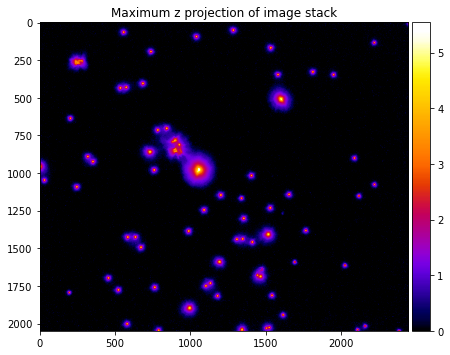

In [9]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(max_proj_norm,
                 out=np.zeros_like(max_proj_norm),
                 where=max_proj_norm!=0)
im = ax.imshow(mpn_log, cmap=fire)
ax.set_title('Maximum z projection of image stack')
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Find features
The appropriate minimum will vary from dataset to dataset. Here a number of minimum masses are experimented with so that the user can select the value they find appropriate.

  0%|          | 0/6 [00:00<?, ?it/s]

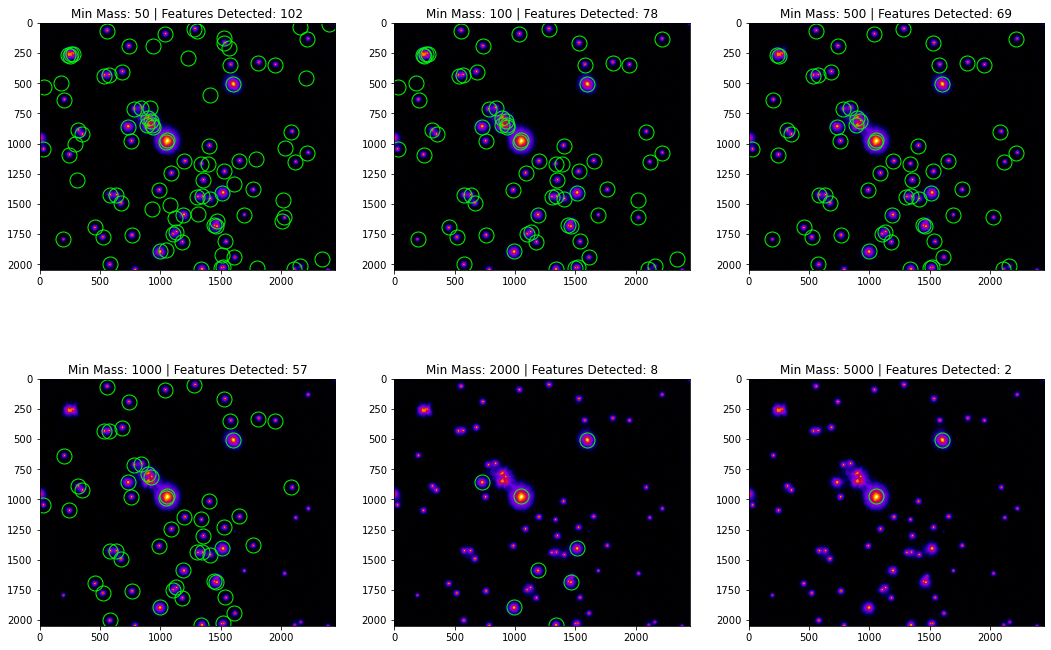

In [10]:
# Set up figure
ncols = 3
nrows = int(np.ceil(len(min_masses) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# Loop through candidate minimum masses
for i, min_mass in tqdm(enumerate(min_masses),
                        total=len(min_masses)):

    # Locate features
    df_features = trackpy.locate(max_proj_norm,
                                 diameter=diameters[1:],  # (y, x) only
                                 minmass=min_mass).reset_index(drop=True)

    # Plot max projection image
    ax = axes.flat[i]
    # Take log to enhance contrast, avoid /b0 error
    mpn_log = np.log(max_proj_norm,
                     out=np.zeros_like(max_proj_norm),
                     where=max_proj_norm!=0)
    ax.imshow(mpn_log, cmap=fire)
    # Plot detected features
    ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
            marker='o', ms=15, mfc='none', mew=1)
    title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
    ax.set_title(title)

#### Find features with chosen minimum mass

In [11]:
# Update value
min_mass = 750

# Locate features
df_features = trackpy.locate(max_proj_norm,
                             diameter=diameters[1:],
                             minmass=min_mass).reset_index(drop=True)
# Display a sample of located features
df_features.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


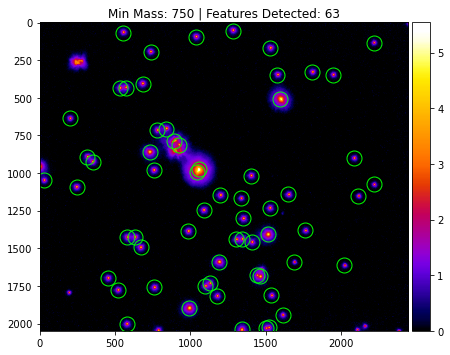

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(max_proj_norm,
                 out=np.zeros_like(max_proj_norm),
                 where=max_proj_norm!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter features based on position

To calculate the PSF, a subvolume is created for each feature. Features with overlapping subvolumes ought to be filtered out. As features are located based on the maximum z projection, this is treated as a 2D problem.

In [13]:
from psf_extractor import bboxes_overlap

In [14]:
# Set bounding box dimensions [μm]
dx_nm = 5
dy_nm = dx_nm

# Convert bounding box dimensions [μm --> px]
dx = dx_nm / psx * 1e3
dy = dy_nm / psy * 1e3

In [15]:
# Create bounding box for each feature based 
# on the dimensions of the subvolume
df_bboxes = df_features.loc[:, ['x', 'y']]

df_bboxes['x_min'] = df_features['x'] - dx/2
df_bboxes['y_min'] = df_features['y'] - dy/2
df_bboxes['x_max'] = df_features['x'] + dx/2
df_bboxes['y_max'] = df_features['y'] + dy/2

df_bboxes.head()

,x,y,x_min,y_min,x_max,y_max
0,1282.117447,53.262390,1243.054947,14.199890,1321.179947,92.324890
1,555.069618,66.516080,516.007118,27.453580,594.132118,105.578580
2,1037.309400,95.478668,998.246900,56.416168,1076.371900,134.541168
3,2216.655063,136.548734,2177.592563,97.486234,2255.717563,175.611234
4,1530.268528,170.191908,1491.206028,131.129408,1569.331028,209.254408


In [16]:
# Collect overlapping features
overlapping_features = []
for i, row_i in tqdm(df_bboxes.iterrows(),
                     total=len(df_bboxes)):
    # Create a bounding boxes for each feature
    bbox_i = row_i[['x_min', 'y_min', 'x_max', 'y_max']].values

    # Check each feature's bbox against every other feature's bbox
    for j, row_j in df_bboxes.iterrows():
        # Skip if i == j
        if i == j:
            continue

        # Create the other feature's bbox
        bbox_j = row_j[['x_min', 'y_min', 'x_max', 'y_max']].values

        # Check overlap
        if bboxes_overlap(bbox_i, bbox_j):
            overlapping_features.append(i)

# Remaining features
df_features.drop(index=overlapping_features, inplace=True)
df_features.head()

  0%|          | 0/63 [00:00<?, ?it/s]

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


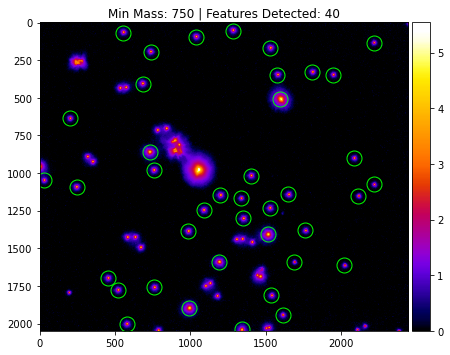

In [17]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(max_proj_norm,
                 out=np.zeros_like(max_proj_norm),
                 where=max_proj_norm!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter based on mass

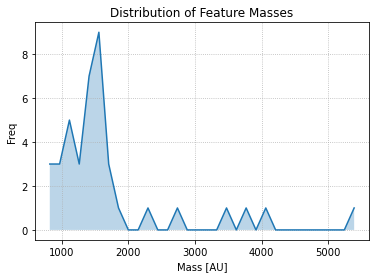

In [18]:
hist, bins = np.histogram(df_features['mass'], bins=32)
bins = (bins[1:] + bins[:-1]) / 2

fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
ax.grid(ls=':')
ax.set_xlabel('Mass [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Feature Masses');

In [19]:
# Not sure what's going on here

In [20]:
#     #Select on mass
#     lenmass = len(features_filt)
#     if lenmass > 12: lenmass /= 2
#     features_filt = features_filt.sort_values('mass').head(n=int(lenmass)).reset_index()

## Fitting
---

### Crop to subvolumes

In [21]:
# Set dimensions of subvolume [μm]
wx_nm = 5
wy_nm = wx_nm
wz_nm = 5

# Convert dimensions of subvolume [μm --> px]
wx = wx_nm / psx * 1e3
wy = wy_nm / psy * 1e3
wz = wz_nm / psz * 1e3

# Compile dimensions (z, y, x)
volume = [wz, wy, wx]
volume

[40.0, 78.125, 78.125]

In [22]:
def create_substacks(features, volume):
    """Create a subvolume for each detected feature

    Parameters
    ----------
    features : `pd.DataFrame`
        DataFrame of located features
    volume : array-like or 3-tuple
        Volume of the substacks to be created (wz, wy, wx)

    Returns
    -------
    substacks : list
        List of all the subvolumes as numpy arrays
    """

    # Extract volume
    wz, wy, wx = volume

    # Collect substacks
    substacks = []
    for i, row in df_features.iterrows():

        x, y = row[['x', 'y']]

        if stack.shape[0] < wz:
            z1, z2 = 0, stack.shape[0]
        else:
            z1, z2 = (int(stack.shape[0]/2 - wz/2),
                      int(stack.shape[0]/2 + wz/2))

        if stack.shape[1] < wy:
            y1, y2 = 0, stack.shape[1]
        else:
            y1, y2 = (int(stack.shape[1]/2 - wy/2),
                      int(stack.shape[1]/2 + wy/2))

        if stack.shape[2] < wx:
            x1, x2 = 0, stack.shape[2]
        else:
            x1, x2 = (int(stack.shape[2]/2 - wx/2),
                      int(stack.shape[2]/2 + wx/2))

        # Create substacks
        substack = stack[z1:z2, y1:y2, x1:x2]
        substacks.append(substack)
        return substacks

In [23]:
substacks = create_substacks(df_features, volume)

### Fit Gaussian

In [ ]:

def psf_gauss_fit(arr):
    centerpos = []
    if len(arr.shape) > 2: #3D stack
        arrz, arry, arrx = arr.shape
        mip = max_int_proj(arr)
        xgp, ygp, _, _, _, _, _ = do_2D_gauss_fit(mip)
        pz = psf_z_gauss_fit(arr, xgp, ygp)
        zgp = pz[0]
        centerpos.append(zgp)
        focim = arr[intround(zgp), :, :]
    else: focim = arr
    x_gp, y_gp, x_si, y_si, rot, maI, miI = do_2D_gauss_fit(focim)
    centerpos.append(y_gp)
    centerpos.append(x_gp)
    if len(arr.shape) > 2:
        #if np.abs(x_gp - xgp) > 1 or np.abs(y_gp - ygp) > 1:
            pz = psf_z_gauss_fit(arr, x_gp, y_gp)
            centerpos[0] = pz[0]
    return focim, centerpos
    

In [ ]:

def do_2D_gauss_fit(arr, thetaest=45):
    arry, arrx = arr.shape
    midx, midy, sigx, sigy, maxI, minI = gauss2D_param(arr)
    p0 = [midx, midy, sigx/4, sigy, thetaest, maxI, minI]
    x, y = np.arange(0, arrx), np.arange(0, arry)
    X, Y = np.meshgrid(x, y)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    popt, pcov = curve_fit(_gaussian_2D, xdata, arr.ravel(), p0, maxfev = 8000)
    return popt #give back all fit values
    